In [ ]:
pip install numpy torch matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 63.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 34.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 82.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

Episode 0, SNR_comm: 91.69, SNR_sense: 83.10, Reward: 6.464, Noise STD: 0.499
Episode 100, SNR_comm: 63.88, SNR_sense: 55.15, Reward: 5.915, Noise STD: 0.452
Episode 200, SNR_comm: 12.57, SNR_sense: 29.71, Reward: 4.352, Noise STD: 0.409
Episode 300, SNR_comm: 87.27, SNR_sense: 87.77, Reward: 6.468, Noise STD: 0.370
Episode 400, SNR_comm: 79.10, SNR_sense: 80.62, Reward: 6.337, Noise STD: 0.335
Episode 500, SNR_comm: 46.36, SNR_sense: 49.97, Reward: 5.619, Noise STD: 0.303
Episode 600, SNR_comm: 85.62, SNR_sense: 84.99, Reward: 6.431, Noise STD: 0.274
Episode 700, SNR_comm: 66.59, SNR_sense: 69.67, Reward: 6.111, Noise STD: 0.248
Episode 800, SNR_comm: 77.11, SNR_sense: 93.50, Reward: 6.425, Noise STD: 0.224
Episode 900, SNR_comm: 84.36, SNR_sense: 67.63, Reward: 6.258, Noise STD: 0.203
Episode 1000, SNR_comm: 76.10, SNR_sense: 81.34, Reward: 6.316, Noise STD: 0.184
Episode 1100, SNR_comm: 62.25, SNR_sense: 47.31, Reward: 5.789, Noise STD: 0.166
Episode 1200, SNR_comm: 67.26, SNR_sense

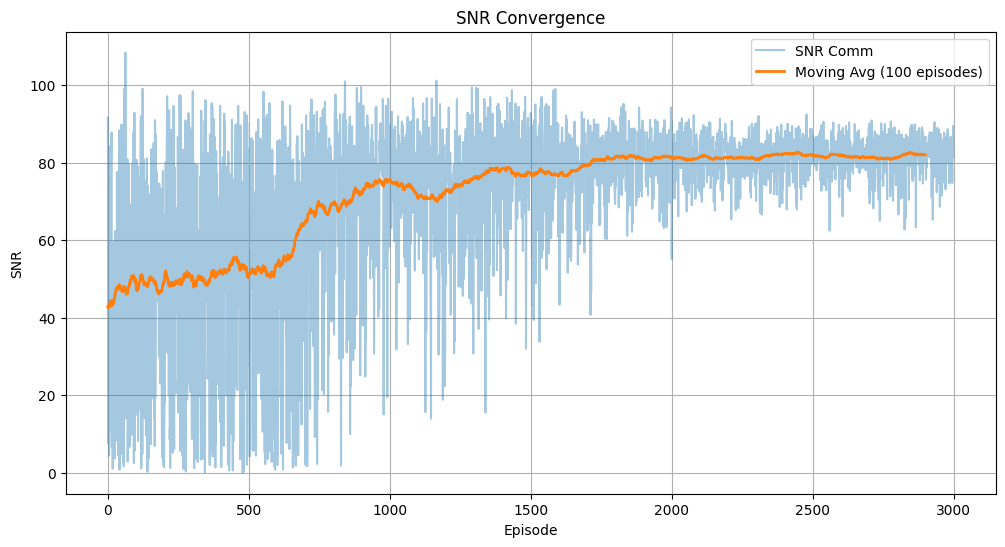

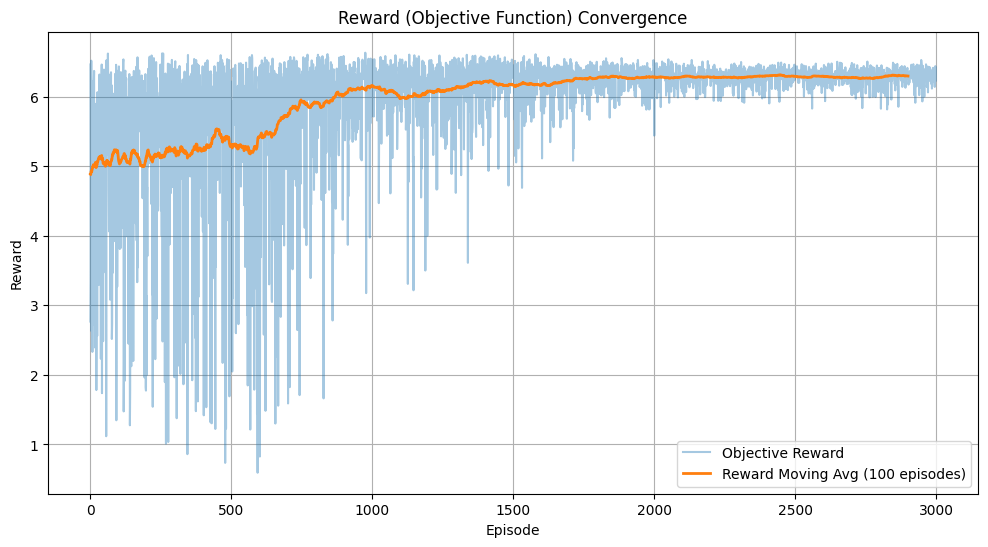

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import random
from collections import deque

# Set random seeds
np.random.seed(42)
torch.manual_seed(42)

# System Parameters
N = 4  # RIS elements
M = 2  # BS antennas
sigma2 = 0.1
P_max = 1
gamma_req = 10 ** (3 / 10)  # (C5) Required SINR threshold in linear scale (~3 dB)
snr_min = 1e-6              # To avoid log(0)
omega = 0.5                 # Weight between comm and sensing secrecy rate

# Fixed channels (complex)
h_ru = (np.random.randn(1, N) + 1j * np.random.randn(1, N)) / np.sqrt(2)
H_br = (np.random.randn(N, M) + 1j * np.random.randn(N, M)) / np.sqrt(2)

def compute_snr(phases, beamforming):
    theta = np.exp(1j * phases)
    theta_diag = np.diag(theta)
    effective_comm = h_ru @ theta_diag @ H_br @ beamforming
    effective_sense = H_br.T.conj() @ theta_diag.T.conj() @ h_ru.T.conj()

    snr_comm = np.abs(effective_comm) ** 2 / sigma2
    snr_sense = np.abs(effective_sense) ** 2 / sigma2

    return snr_comm.ravel()[0].real, snr_sense.ravel()[0].real


# Replay Buffer
class ReplayBuffer:
    def __init__(self, capacity=10000):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state):
        self.buffer.append((state, action, reward, next_state))

    def sample(self, batch_size):
        samples = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states = map(np.vstack, zip(*samples))
        return torch.FloatTensor(states), torch.FloatTensor(actions), torch.FloatTensor(rewards), torch.FloatTensor(next_states)

    def __len__(self):
        return len(self.buffer)

# Actor Network
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_dim)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        return torch.tanh(self.fc3(x))

# Critic Network
class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_dim + action_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 1)

    def forward(self, state, action):
        x = torch.cat([state, action], dim=-1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Hyperparameters
state_dim = N + M
action_dim = N + M
num_episodes = 3000
batch_size = 64
gamma = 0.99
tau = 0.005
noise_std = 0.5
noise_decay = 0.999
min_noise_std = 0.05

# Initialize
actor = Actor(state_dim, action_dim)
critic = Critic(state_dim, action_dim)
target_actor = Actor(state_dim, action_dim)
target_critic = Critic(state_dim, action_dim)
target_actor.load_state_dict(actor.state_dict())
target_critic.load_state_dict(critic.state_dict())
actor_optimizer = optim.Adam(actor.parameters(), lr=1e-3)
critic_optimizer = optim.Adam(critic.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()
replay_buffer = ReplayBuffer()

# Tracking
snr_history = []
critic_losses = []
actor_losses = []
reward_history = []

# Training Loop
for episode in range(num_episodes):
    ris_phases = np.random.uniform(0, 2 * np.pi, N)
    bs_w = np.random.randn(M)
    bs_w = bs_w / np.linalg.norm(bs_w) * np.sqrt(P_max)
    state_np = np.concatenate([ris_phases, bs_w])
    state = torch.FloatTensor(state_np).unsqueeze(0)

    action = actor(state).detach().numpy()[0]
    noisy_action = action + np.random.normal(0, noise_std, size=action_dim)

    ris_action = np.mod((noisy_action[:N] + 1) / 2 * 2 * np.pi, 2 * np.pi)
    bs_action_raw = (noisy_action[N:] + 1) / 2 * 2 - 1
    bs_action = bs_action_raw / np.linalg.norm(bs_action_raw) * np.sqrt(P_max)

    snr_comm, snr_sense = compute_snr(ris_action, bs_action.reshape(-1, 1))
    snr_comm = max(snr_comm, snr_min)
    snr_sense = max(snr_sense, snr_min)
    reward = omega * np.log2(1 + snr_comm) + (1 - omega) * np.log2(1 + snr_sense)
    reward_history.append(reward)


    next_state_np = np.concatenate([ris_action, bs_action])
    next_state = torch.FloatTensor(next_state_np).unsqueeze(0)
    replay_buffer.push(state_np, noisy_action, [reward], next_state_np)

    if len(replay_buffer) >= batch_size:
        states, actions, rewards, next_states = replay_buffer.sample(batch_size)
        with torch.no_grad():
            next_actions = target_actor(next_states)
            target_q = rewards + gamma * target_critic(next_states, next_actions)
        current_q = critic(states, actions)
        critic_loss = loss_fn(current_q, target_q)
        critic_optimizer.zero_grad()
        critic_loss.backward()
        critic_optimizer.step()

        actor_loss = -critic(states, actor(states)).mean()
        actor_optimizer.zero_grad()
        actor_loss.backward()
        actor_optimizer.step()

        for t_p, p in zip(target_actor.parameters(), actor.parameters()):
            t_p.data.copy_(tau * p.data + (1 - tau) * t_p.data)
        for t_p, p in zip(target_critic.parameters(), critic.parameters()):
            t_p.data.copy_(tau * p.data + (1 - tau) * t_p.data)

    snr_history.append(snr_comm)
    noise_std = max(noise_std * noise_decay, min_noise_std)

    if episode % 100 == 0:
        print(f"Episode {episode}, SNR_comm: {snr_comm:.2f}, SNR_sense: {snr_sense:.2f}, Reward: {reward:.3f}, Noise STD: {noise_std:.3f}")

# Plot Functions
def moving_average(data, window_size=100):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

plt.figure(figsize=(12,6))
plt.plot(snr_history, label='SNR Comm', alpha=0.4)
plt.plot(moving_average(snr_history), label='Moving Avg (100 episodes)', linewidth=2)
plt.xlabel('Episode')
plt.ylabel('SNR')
plt.title('SNR Convergence')
plt.legend()
plt.grid(True)
plt.show()

# Plot 4: Reward (Objective Value)
plt.figure(figsize=(12,6))
plt.plot(reward_history, label='Objective Reward', alpha=0.4)
plt.plot(moving_average(reward_history), label='Reward Moving Avg (100 episodes)', linewidth=2)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Reward (Objective Function) Convergence')
plt.legend()
plt.grid(True)
plt.show()



Episode 0, SNR_comm: 91.69, SNR_sense: 83.10, Reward: 6.464, Noise STD: 0.499
Episode 100, SNR_comm: 63.88, SNR_sense: 55.15, Reward: 5.915, Noise STD: 0.452
Episode 200, SNR_comm: 12.57, SNR_sense: 29.71, Reward: 4.352, Noise STD: 0.409
Episode 300, SNR_comm: 87.27, SNR_sense: 87.77, Reward: 6.468, Noise STD: 0.370
Episode 400, SNR_comm: 79.10, SNR_sense: 80.62, Reward: 6.337, Noise STD: 0.335
Episode 500, SNR_comm: 46.36, SNR_sense: 49.97, Reward: 5.619, Noise STD: 0.303
Episode 600, SNR_comm: 85.62, SNR_sense: 84.99, Reward: 6.431, Noise STD: 0.274
Episode 700, SNR_comm: 66.58, SNR_sense: 69.65, Reward: 6.111, Noise STD: 0.248
Episode 800, SNR_comm: 92.87, SNR_sense: 93.50, Reward: 6.557, Noise STD: 0.224
Episode 900, SNR_comm: 84.36, SNR_sense: 67.63, Reward: 6.258, Noise STD: 0.203
Episode 1000, SNR_comm: 76.10, SNR_sense: 81.34, Reward: 6.316, Noise STD: 0.184
Episode 1100, SNR_comm: 62.25, SNR_sense: 47.31, Reward: 5.789, Noise STD: 0.166
Episode 1200, SNR_comm: 67.23, SNR_sense

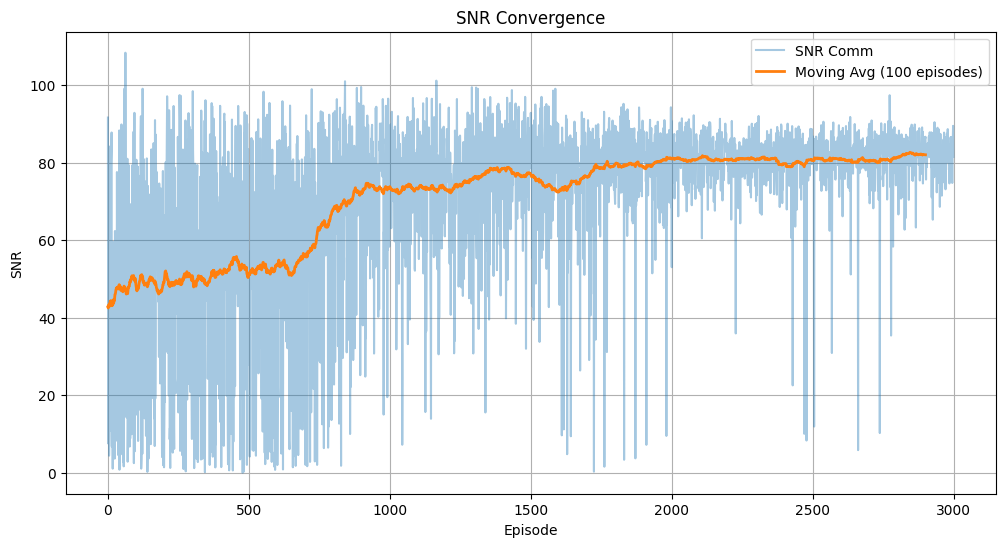

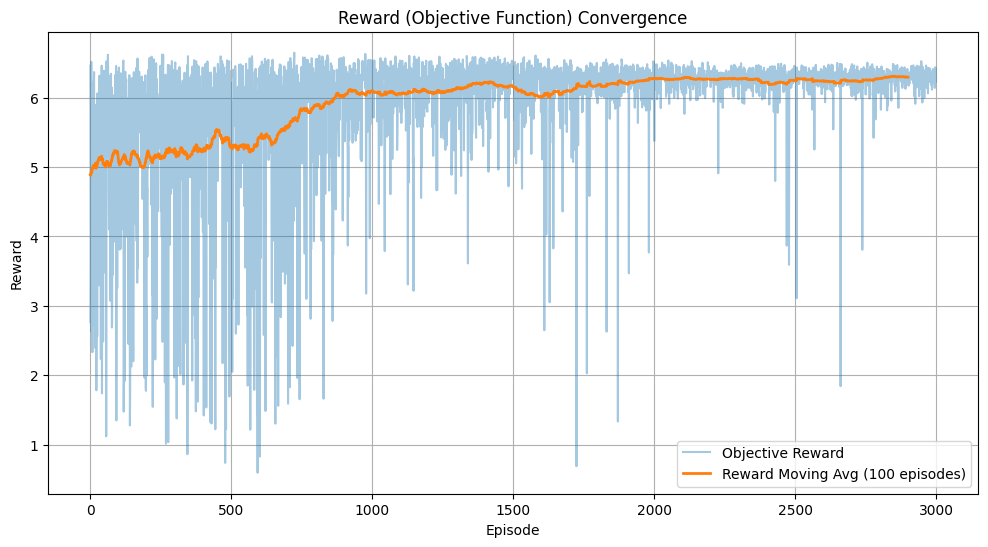

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import random
from collections import deque

# ===================== System Parameters =====================
np.random.seed(42)
torch.manual_seed(42)

# RIS and BS configuration
N = 4  # RIS elements
M = 2  # BS antennas
sigma2 = 0.1  # Noise variance

# Power and threshold
P_max = 1
gamma_req = 10 ** (3 / 10)  # SINR threshold (linear), Eq. (14)
snr_min = 1e-6              # Avoid log(0)
omega = 0.5                 # Weight between comm and sensing secrecy rate, Eq. (23), (25)

# ===================== Channel Definitions =====================
# Fixed channels (complex), used in Eq. (13)-(14)
h_ru = (np.random.randn(1, N) + 1j * np.random.randn(1, N)) / np.sqrt(2)  # RIS to UE
H_br = (np.random.randn(N, M) + 1j * np.random.randn(N, M)) / np.sqrt(2)  # BS to RIS

# ===================== Compute SNRs (Eq. 14, 19) =====================
def compute_snr(phases, beamforming):
    theta = np.exp(1j * phases)  # Eq. (1)
    theta_diag = np.diag(theta)
    effective_comm = h_ru @ theta_diag @ H_br @ beamforming
    effective_sense = H_br.T.conj() @ theta_diag.T.conj() @ h_ru.T.conj()

    snr_comm = np.abs(effective_comm) ** 2 / sigma2  # Eq. (14) numerator approximation
    snr_sense = np.abs(effective_sense) ** 2 / sigma2  # Eq. (19) sensing SNR

    return snr_comm.ravel()[0].real, snr_sense.ravel()[0].real

# ===================== Replay Buffer =====================
class ReplayBuffer:
    def __init__(self, capacity=10000):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state):
        self.buffer.append((state, action, reward, next_state))

    def sample(self, batch_size):
        samples = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states = map(np.vstack, zip(*samples))
        return torch.FloatTensor(states), torch.FloatTensor(actions), torch.FloatTensor(rewards), torch.FloatTensor(next_states)

    def __len__(self):
        return len(self.buffer)

# ===================== Actor-Critic Networks =====================
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_dim)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        return torch.tanh(self.fc3(x))

class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_dim + action_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 1)

    def forward(self, state, action):
        x = torch.cat([state, action], dim=-1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# ===================== Hyperparameters =====================
state_dim = N + M
action_dim = N + M
num_episodes = 3000
batch_size = 64
gamma = 0.99
tau = 0.005
noise_std = 0.5
noise_decay = 0.999
min_noise_std = 0.05

# ===================== Initialize Networks and Optimizers =====================
actor = Actor(state_dim, action_dim)
critic = Critic(state_dim, action_dim)
target_actor = Actor(state_dim, action_dim)
target_critic = Critic(state_dim, action_dim)
target_actor.load_state_dict(actor.state_dict())
target_critic.load_state_dict(critic.state_dict())
actor_optimizer = optim.Adam(actor.parameters(), lr=1e-3)
critic_optimizer = optim.Adam(critic.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()
replay_buffer = ReplayBuffer()

# ===================== Tracking =====================
snr_history = []
reward_history = []

# ===================== Training Loop =====================
for episode in range(num_episodes):
    ris_phases = np.random.uniform(0, 2 * np.pi, N)
    bs_w = np.random.randn(M)
    bs_w = bs_w / np.linalg.norm(bs_w) * np.sqrt(P_max)
    state_np = np.concatenate([ris_phases, bs_w])
    state = torch.FloatTensor(state_np).unsqueeze(0)

    action = actor(state).detach().numpy()[0]
    noisy_action = action + np.random.normal(0, noise_std, size=action_dim)

    ris_action = np.mod((noisy_action[:N] + 1) / 2 * 2 * np.pi, 2 * np.pi)
    bs_action_raw = (noisy_action[N:] + 1) / 2 * 2 - 1
    bs_action = bs_action_raw / np.linalg.norm(bs_action_raw) * np.sqrt(P_max)

    snr_comm, snr_sense = compute_snr(ris_action, bs_action.reshape(-1, 1))
    snr_comm = max(snr_comm, snr_min)
    snr_sense = max(snr_sense, snr_min)

    # Eq. (23) + (25) inspired reward function: weighted secrecy metric
    reward = omega * np.log2(1 + snr_comm) + (1 - omega) * np.log2(1 + snr_sense)
    reward_history.append(reward)

    next_state_np = np.concatenate([ris_action, bs_action])
    next_state = torch.FloatTensor(next_state_np).unsqueeze(0)
    replay_buffer.push(state_np, noisy_action, [reward], next_state_np)

    if len(replay_buffer) >= batch_size:
        states, actions, rewards, next_states = replay_buffer.sample(batch_size)
        with torch.no_grad():
            next_actions = target_actor(next_states)
            target_q = rewards + gamma * target_critic(next_states, next_actions)
        current_q = critic(states, actions)
        critic_loss = loss_fn(current_q, target_q)
        critic_optimizer.zero_grad()
        critic_loss.backward()
        critic_optimizer.step()

        actor_loss = -critic(states, actor(states)).mean()
        actor_optimizer.zero_grad()
        actor_loss.backward()
        actor_optimizer.step()

        # Soft update for target networks
        for t_p, p in zip(target_actor.parameters(), actor.parameters()):
            t_p.data.copy_(tau * p.data + (1 - tau) * t_p.data)
        for t_p, p in zip(target_critic.parameters(), critic.parameters()):
            t_p.data.copy_(tau * p.data + (1 - tau) * t_p.data)

    snr_history.append(snr_comm)
    noise_std = max(noise_std * noise_decay, min_noise_std)

    if episode % 100 == 0:
        print(f"Episode {episode}, SNR_comm: {snr_comm:.2f}, SNR_sense: {snr_sense:.2f}, Reward: {reward:.3f}, Noise STD: {noise_std:.3f}")

# ===================== Visualization =====================
def moving_average(data, window_size=100):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# SNR Plot
plt.figure(figsize=(12,6))
plt.plot(snr_history, label='SNR Comm', alpha=0.4)
plt.plot(moving_average(snr_history), label='Moving Avg (100 episodes)', linewidth=2)
plt.xlabel('Episode')
plt.ylabel('SNR')
plt.title('SNR Convergence')
plt.legend()
plt.grid(True)
plt.show()

# Reward Plot
plt.figure(figsize=(12,6))
plt.plot(reward_history, label='Objective Reward', alpha=0.4)
plt.plot(moving_average(reward_history), label='Reward Moving Avg (100 episodes)', linewidth=2)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Reward (Objective Function) Convergence')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# =======================================
# Secure-ISAC DDPG – single BS & RIS demo
# =======================================

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque

# ---------- System parameters ----------
N, M = 4, 2                     # RIS elements, BS antennas
sigma2 = 0.1                    # Noise variance
P_max  = 1.0                    # BS power budget
snr_min = 1e-6                  # Avoid log(0)
omega   = 0.5                   # Comm-vs-sensing weight (Eq. 23 & 25)
beta, B = 0.8, 1.0              # Access bandwidth split & total BW

# ---------- Channels (Rayleigh) ----------
h_ru = (np.random.randn(1, N) + 1j*np.random.randn(1, N)) / np.sqrt(2)
H_br = (np.random.randn(N, M) + 1j*np.random.randn(N, M)) / np.sqrt(2)
h_e  = (np.random.randn(1, N) + 1j*np.random.randn(1, N)) / np.sqrt(2)
H_be = (np.random.randn(N, M) + 1j*np.random.randn(N, M)) / np.sqrt(2)

# ---------- Helper: always return float ----------
def _scalar(x: np.ndarray) -> float:
    """Return a real scalar even if x is (1,1) or longer."""
    x = np.real(x).ravel()
    return float(x[0])

def compute_snr(phases, w):
    θ = np.exp(1j*phases)
    Θ = np.diag(θ)
    # Comm   (user): h_ru Θ H_br w
    eff_c = h_ru @ Θ @ H_br @ w
    # Sensing (radar): H_br^H Θ^H h_ru^H
    eff_s = H_br.T.conj() @ Θ.T.conj() @ h_ru.T.conj()
    snr_c = np.abs(eff_c)**2 / sigma2
    snr_s = np.abs(eff_s)**2 / sigma2
    return _scalar(snr_c), _scalar(snr_s)

def compute_eve_snr(phases, w):
    θ = np.exp(1j*phases)
    Θ = np.diag(θ)
    eff_e = h_e @ Θ @ H_be @ w
    snr_e = np.abs(eff_e)**2 / sigma2
    return _scalar(snr_e)

# ---------- Replay buffer ----------
class Buffer:
    def __init__(self, cap=10_000): self.buf = deque(maxlen=cap)
    def push(self, s, a, r, s2):     self.buf.append((s, a, r, s2))
    def sample(self, k):
        samp = random.sample(self.buf, k)
        s,a,r,s2 = map(np.vstack, zip(*samp))
        return map(torch.tensor, (s,a,r,s2))
    def __len__(self): return len(self.buf)

# ---------- Actor / Critic ----------
class Actor(nn.Module):
    def __init__(self, n_in, n_out):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_in,128), nn.ReLU(),
            nn.Linear(128,128),   nn.ReLU(),
            nn.Linear(128,n_out), nn.Tanh())
    def forward(self,x): return self.net(x)

class Critic(nn.Module):
    def __init__(self, n_state, n_act):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_state+n_act,128), nn.ReLU(),
            nn.Linear(128,128),           nn.ReLU(),
            nn.Linear(128,1))
    def forward(self,s,a): return self.net(torch.cat([s,a],-1))

# ---------- Hyper-parameters ----------
state_dim   = N + M
action_dim  = N + M
episodes    = 3000
batch_sz    = 64
γ, τ        = 0.99, 0.005
noise_std   = 0.5
decay, σmin = 0.999, 0.05

# ---------- Initialise RL objects ----------
actor  = Actor(state_dim, action_dim)
critic = Critic(state_dim, action_dim)
t_actor  = Actor(state_dim, action_dim); t_actor.load_state_dict(actor.state_dict())
t_critic = Critic(state_dim, action_dim); t_critic.load_state_dict(critic.state_dict())
optA = optim.Adam(actor.parameters(),  1e-3)
optC = optim.Adam(critic.parameters(), 1e-3)
buf  = Buffer()

snr_log, rew_log = [], []

# ---------- Training loop ----------
for ep in range(episodes):
    # random initial RIS phases & feasible BS beam
    φ = np.random.uniform(0, 2*np.pi, N)
    w = np.random.randn(M); w = w/np.linalg.norm(w)*np.sqrt(P_max)
    state = np.concatenate([φ, w])             # (N+M,)
    s_t   = torch.tensor(state).float().unsqueeze(0)

    # Actor + exploration noise
    act = actor(s_t).detach().numpy()[0]
    act += np.random.normal(0, noise_std, action_dim)

    # Split action -> RIS phases & beam weights
    φ_new = np.mod((act[:N]+1)/2 * 2*np.pi, 2*np.pi)
    w_raw = (act[N:]+1)/2 * 2 - 1
    w_new = w_raw/np.linalg.norm(w_raw)*np.sqrt(P_max)

    # ---------- SNRs ----------
    snr_c, snr_s = compute_snr(φ_new, w_new.reshape(-1,1))
    snr_e        = compute_eve_snr(φ_new, w_new.reshape(-1,1))

    snr_c, snr_s, snr_e = map(lambda x: max(x, snr_min), (snr_c,snr_s,snr_e))

    # ---------- Rates & reward ----------
    R_v = beta*B*np.log2(1+snr_c)
    R_e = beta*B*np.log2(1+snr_e)
    SecRate = max(R_v - R_e, 0)          # Eq. 23
    SenRate = beta*B*np.log2(1+snr_s)    # Eq. 25 (without eaves in sensing path)
    reward  = omega*SecRate + (1-omega)*SenRate

    # ---------- Buffer update ----------
    next_state = np.concatenate([φ_new, w_new])
    buf.push(state, act, [reward], next_state)

    # ---------- Learn ----------
    if len(buf) >= batch_sz:
        S,A,R,S2 = buf.sample(batch_sz)
        S  = S.float(); A = A.float(); R = R.float(); S2 = S2.float()

        with torch.no_grad():
            A2 = t_actor(S2)
            y  = R + γ * t_critic(S2, A2)
        q = critic(S, A)
        optC.zero_grad(); nn.MSELoss()(q, y).backward(); optC.step()

        optA.zero_grad(); (-critic(S, actor(S)).mean()).backward(); optA.step()

        for tp,p in zip(t_actor.parameters(), actor.parameters()):
            tp.data.copy_(τ*p.data + (1-τ)*tp.data)
        for tp,p in zip(t_critic.parameters(), critic.parameters()):
            tp.data.copy_(τ*p.data + (1-τ)*tp.data)

    # ---------- Logs ----------
    snr_log.append(snr_c)
    rew_log.append(reward)
    noise_std = max(noise_std*decay, σmin)

    if ep % 200 == 0:
        print(f"Ep {ep:4d}: SNR={snr_c:6.2f}, SecRate={SecRate:5.3f}, Rew={reward:5.3f}")

# ---------- Quick summary ----------
import pandas as pd
print(pd.DataFrame({'SNR_comm':snr_log, 'Reward':rew_log}).head())


Ep    0: SNR= 16.77, SecRate=0.000, Rew=2.290
Ep  200: SNR= 11.35, SecRate=0.000, Rew=2.100
Ep  400: SNR=126.73, SecRate=0.000, Rew=1.584
Ep  600: SNR= 72.86, SecRate=2.405, Rew=3.342
Ep  800: SNR= 26.54, SecRate=0.000, Rew=2.004
Ep 1000: SNR= 35.26, SecRate=0.000, Rew=2.358
Ep 1200: SNR= 32.21, SecRate=0.000, Rew=1.964
Ep 1400: SNR= 27.76, SecRate=0.000, Rew=2.341
Ep 1600: SNR= 33.18, SecRate=0.000, Rew=2.132
Ep 1800: SNR= 30.09, SecRate=0.000, Rew=2.264
Ep 2000: SNR= 37.62, SecRate=0.000, Rew=2.365
Ep 2200: SNR= 26.35, SecRate=0.000, Rew=2.284
Ep 2400: SNR= 33.11, SecRate=0.000, Rew=2.176
Ep 2600: SNR= 32.98, SecRate=0.000, Rew=2.118
Ep 2800: SNR= 25.41, SecRate=0.000, Rew=2.337
    SNR_comm    Reward
0  16.768871  2.289878
1  32.711110  2.099184
2   5.299114  2.079225
3  31.544220  2.571144
4  44.542784  2.456749


Episode 0, SNR: 1.64, Reward: 1.226
Episode 200, SNR: 218.20, Reward: 3.182
Episode 400, SNR: 222.63, Reward: 3.362
Episode 600, SNR: 246.62, Reward: 3.303
Episode 800, SNR: 221.36, Reward: 3.087
Episode 1000, SNR: 236.93, Reward: 3.222
Episode 1200, SNR: 238.71, Reward: 3.382
Episode 1400, SNR: 244.54, Reward: 3.332
Episode 1600, SNR: 247.85, Reward: 3.334
Episode 1800, SNR: 238.34, Reward: 3.144
Episode 2000, SNR: 226.29, Reward: 3.391
Episode 2200, SNR: 237.38, Reward: 3.398
Episode 2400, SNR: 240.40, Reward: 3.231
Episode 2600, SNR: 244.77, Reward: 3.301
Episode 2800, SNR: 239.38, Reward: 3.328


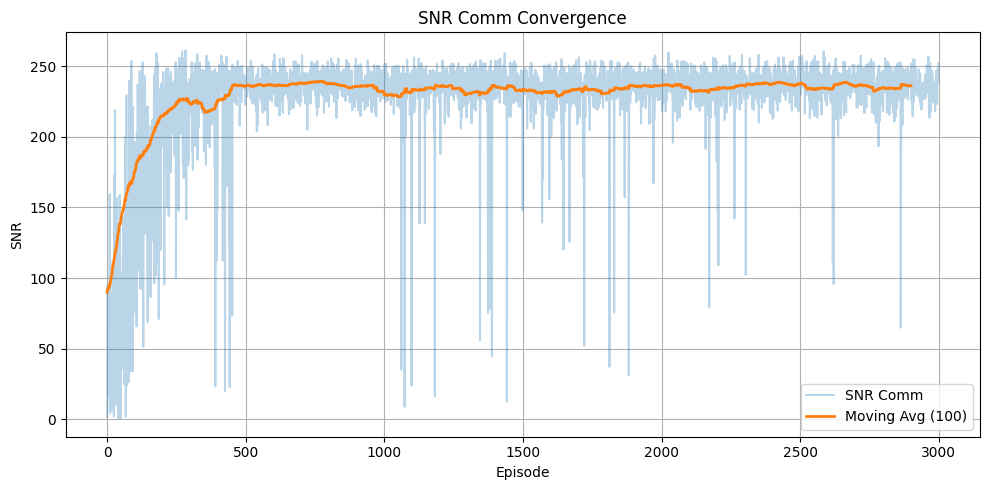

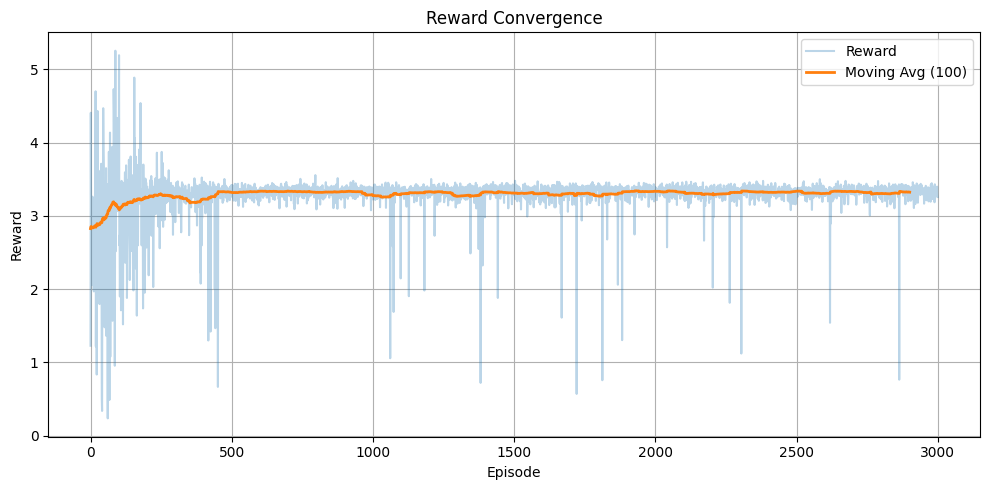

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import matplotlib.pyplot as plt

# === System Parameters ===
N, M = 4, 2
sigma2 = 0.1
P_max = 1
snr_min = 1e-6
omega = 0.5
beta, B = 0.8, 1.0

# === Channels ===
h_ru = (np.random.randn(1, N) + 1j*np.random.randn(1, N)) / np.sqrt(2)
H_br = (np.random.randn(N, M) + 1j*np.random.randn(N, M)) / np.sqrt(2)
h_e  = (np.random.randn(1, N) + 1j*np.random.randn(1, N)) / np.sqrt(2)
H_be = (np.random.randn(N, M) + 1j*np.random.randn(N, M)) / np.sqrt(2)

# === Helper functions ===
def _scalar(x): return float(np.real(x).ravel()[0])

def compute_snr(phases, w):
    theta = np.exp(1j * phases)
    Theta = np.diag(theta)
    eff_c = h_ru @ Theta @ H_br @ w
    eff_s = H_br.T.conj() @ Theta.T.conj() @ h_ru.T.conj()
    snr_c = np.abs(eff_c)**2 / sigma2
    snr_s = np.abs(eff_s)**2 / sigma2
    return _scalar(snr_c), _scalar(snr_s)

def compute_eve_snr(phases, w):
    theta = np.exp(1j * phases)
    Theta = np.diag(theta)
    eff_e = h_e @ Theta @ H_be @ w
    snr_e = np.abs(eff_e)**2 / sigma2
    return _scalar(snr_e)

# === Replay Buffer ===
class ReplayBuffer:
    def __init__(self, capacity=10000):
        self.buffer = deque(maxlen=capacity)
    def push(self, s, a, r, s2):
        self.buffer.append((s, a, r, s2))
    def sample(self, batch_size):
        samples = random.sample(self.buffer, batch_size)
        s, a, r, s2 = map(np.vstack, zip(*samples))
        return map(torch.FloatTensor, (s, a, r, s2))
    def __len__(self): return len(self.buffer)

# === Actor and Critic ===
class Actor(nn.Module):
    def __init__(self, s_dim, a_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(s_dim, 128), nn.ReLU(),
            nn.Linear(128, 128), nn.ReLU(),
            nn.Linear(128, a_dim), nn.Tanh())
    def forward(self, s): return self.net(s)

class Critic(nn.Module):
    def __init__(self, s_dim, a_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(s_dim + a_dim, 128), nn.ReLU(),
            nn.Linear(128, 128), nn.ReLU(),
            nn.Linear(128, 1))
    def forward(self, s, a): return self.net(torch.cat([s, a], dim=-1))

# === Hyperparameters ===
state_dim = N + M
action_dim = N + M
episodes = 3000
batch_size = 64
gamma = 0.99
tau = 0.005
noise_std = 0.5
noise_decay = 0.995
min_noise_std = 0.05

# === Initialization ===
actor = Actor(state_dim, action_dim)
critic = Critic(state_dim, action_dim)
target_actor = Actor(state_dim, action_dim)
target_critic = Critic(state_dim, action_dim)
target_actor.load_state_dict(actor.state_dict())
target_critic.load_state_dict(critic.state_dict())
opt_actor = optim.Adam(actor.parameters(), lr=1e-3)
opt_critic = optim.Adam(critic.parameters(), lr=1e-3)
replay_buffer = ReplayBuffer()

snr_log, reward_log = [], []

# === Training Loop ===
for ep in range(episodes):
    ris_phases = np.random.uniform(0, 2 * np.pi, N)
    bs_w = np.random.randn(M)
    bs_w = bs_w / np.linalg.norm(bs_w) * np.sqrt(P_max)
    state_np = np.concatenate([ris_phases, bs_w])
    state = torch.FloatTensor(state_np).unsqueeze(0)

    action = actor(state).detach().numpy()[0]
    noisy_action = action + np.random.normal(0, noise_std, action_dim)

    ris_action = np.mod((noisy_action[:N] + 1) / 2 * 2 * np.pi, 2 * np.pi)
    bs_raw = (noisy_action[N:] + 1) / 2 * 2 - 1
    bs_action = bs_raw / np.linalg.norm(bs_raw) * np.sqrt(P_max)

    snr_comm, snr_sense = compute_snr(ris_action, bs_action.reshape(-1,1))
    snr_eve = compute_eve_snr(ris_action, bs_action.reshape(-1,1))
    snr_comm = max(snr_comm, snr_min)
    snr_sense = max(snr_sense, snr_min)
    snr_eve = max(snr_eve, snr_min)

    R_v = beta * B * np.log2(1 + snr_comm)
    R_e = beta * B * np.log2(1 + snr_eve)
    secrecy_rate = max(R_v - R_e, 0)
    sensing_rate = beta * B * np.log2(1 + snr_sense)
    reward = omega * secrecy_rate + (1 - omega) * sensing_rate

    snr_log.append(snr_comm)
    reward_log.append(reward)

    next_state_np = np.concatenate([ris_action, bs_action])
    replay_buffer.push(state_np, noisy_action, [reward], next_state_np)

    if len(replay_buffer) >= batch_size:
        s, a, r, s2 = replay_buffer.sample(batch_size)
        with torch.no_grad():
            a2 = target_actor(s2)
            target_q = r + gamma * target_critic(s2, a2)
        q = critic(s, a)
        critic_loss = nn.MSELoss()(q, target_q)
        opt_critic.zero_grad(); critic_loss.backward(); opt_critic.step()

        actor_loss = -critic(s, actor(s)).mean()
        opt_actor.zero_grad(); actor_loss.backward(); opt_actor.step()

        for tp, p in zip(target_actor.parameters(), actor.parameters()):
            tp.data.copy_(tau * p.data + (1 - tau) * tp.data)
        for tp, p in zip(target_critic.parameters(), critic.parameters()):
            tp.data.copy_(tau * p.data + (1 - tau) * tp.data)

    noise_std = max(noise_std * noise_decay, min_noise_std)

    if ep % 200 == 0:
        print(f"Episode {ep}, SNR: {snr_comm:.2f}, Reward: {reward:.3f}")

# === Plot Results ===
def moving_avg(x, k=100):
    return np.convolve(x, np.ones(k)/k, mode='valid')

plt.figure(figsize=(10,5))
plt.plot(snr_log, label="SNR Comm", alpha=0.3)
plt.plot(moving_avg(snr_log), label="Moving Avg (100)", linewidth=2)
plt.title("SNR Comm Convergence")
plt.xlabel("Episode"); plt.ylabel("SNR")
plt.grid(True); plt.legend(); plt.tight_layout()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(reward_log, label="Reward", alpha=0.3)
plt.plot(moving_avg(reward_log), label="Moving Avg (100)", linewidth=2)
plt.title("Reward Convergence")
plt.xlabel("Episode"); plt.ylabel("Reward")
plt.grid(True); plt.legend(); plt.tight_layout()
plt.show()


Episode 0, Secrecy: 2.3103, Sensing: 1.8596, Reward: 2.0850
Episode 100, Secrecy: 1.0858, Sensing: 4.6296, Reward: 2.8577
Episode 200, Secrecy: 0.9592, Sensing: 4.4722, Reward: 2.7157
Episode 300, Secrecy: 0.8192, Sensing: 5.0214, Reward: 2.9203
Episode 400, Secrecy: 2.7474, Sensing: 4.6313, Reward: 3.6894
Episode 500, Secrecy: 2.7680, Sensing: 5.2090, Reward: 3.9885
Episode 600, Secrecy: 2.6124, Sensing: 4.7250, Reward: 3.6687
Episode 700, Secrecy: 3.1082, Sensing: 4.9946, Reward: 4.0514
Episode 800, Secrecy: 3.1633, Sensing: 4.8114, Reward: 3.9874
Episode 900, Secrecy: 2.7800, Sensing: 4.9838, Reward: 3.8819


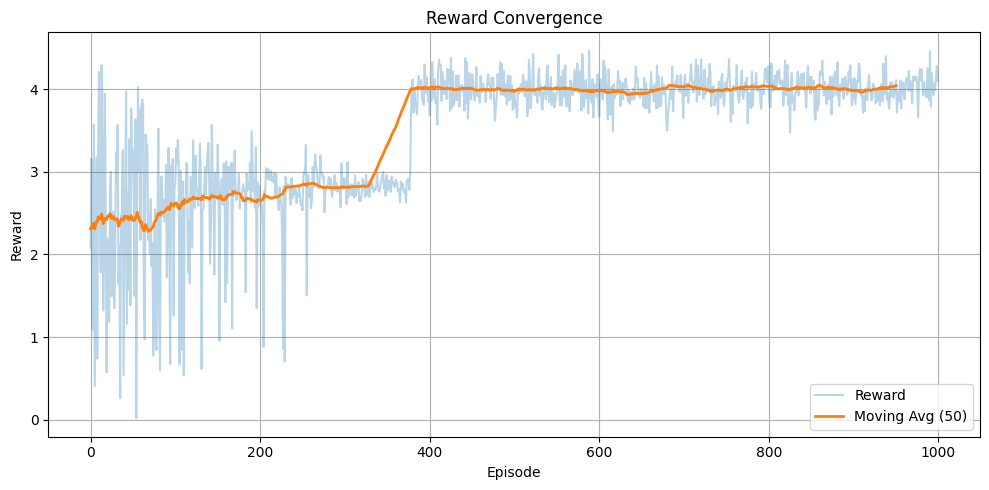

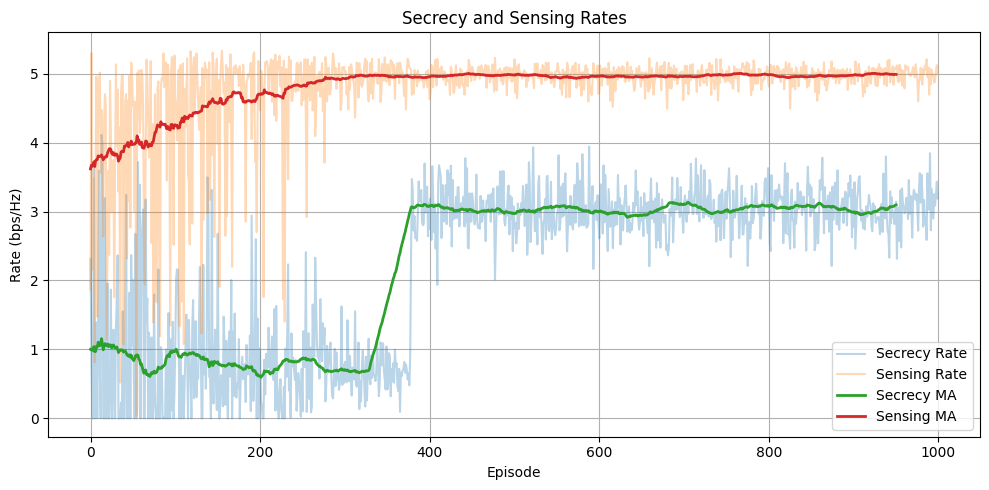

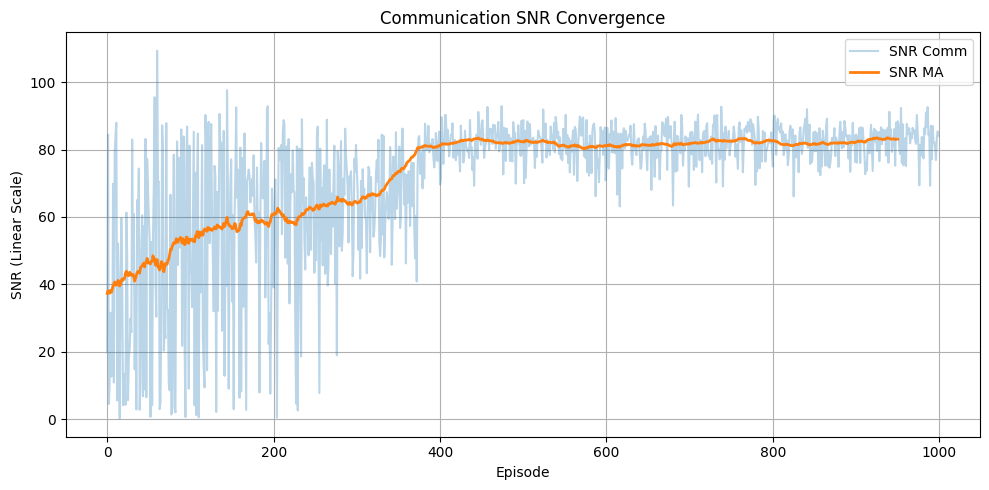

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import matplotlib.pyplot as plt

# === Set seed for reproducibility ===
np.random.seed(42)
torch.manual_seed(42)

# === System Parameters (JSAC Equation References) ===
N, M = 4, 2                      # RIS elements (Θ), BS antennas (W_τ, W_o)
sigma2 = 0.1                    # Noise variance (Eq. 14, 16, 19)
P_max = 1                       # Max transmit power constraint
snr_min = 1e-6                  # Avoid log(0)
omega = 0.5                     # Reward weighting between secrecy & sensing
beta, B = 0.8, 1.0              # Bandwidth partitioning (Eq. 20–25)

# === Fixed Channels (as per Section II.B) ===
h_ru = (np.random.randn(1, N) + 1j*np.random.randn(1, N)) / np.sqrt(2)
H_br = (np.random.randn(N, M) + 1j*np.random.randn(N, M)) / np.sqrt(2)
h_e  = (np.random.randn(1, N) + 1j*np.random.randn(1, N)) / np.sqrt(2)
H_be = (np.random.randn(N, M) + 1j*np.random.randn(N, M)) / np.sqrt(2)

def _scalar(x): return float(np.real(x).ravel()[0])

# === SNR Computation for legitimate and sensing paths (Eq. 14 & 19) ===
def compute_snr(phases, w):
    theta = np.exp(1j * phases)
    Theta = np.diag(theta)
    eff_comm = h_ru @ Theta @ H_br @ w
    eff_sense = H_br.T.conj() @ Theta.T.conj() @ h_ru.T.conj()
    snr_comm = np.abs(eff_comm)**2 / sigma2
    snr_sense = np.abs(eff_sense)**2 / sigma2
    return _scalar(snr_comm), _scalar(snr_sense)

# === Eavesdropper SNR (Eq. 16, max-power heuristic) ===
def compute_eve_snr(phases, w):
    theta = np.exp(1j * phases)
    Theta = np.diag(theta)
    eff_e = h_e @ Theta @ H_be @ w
    snr_e = np.abs(eff_e)**2 / sigma2
    return _scalar(snr_e)

# === Replay Buffer ===
class ReplayBuffer:
    def __init__(self, capacity=10000):
        self.buffer = deque(maxlen=capacity)
    def push(self, s, a, r, s2):
        self.buffer.append((s, a, r, s2))
    def sample(self, batch_size):
        samples = random.sample(self.buffer, batch_size)
        s, a, r, s2 = map(np.vstack, zip(*samples))
        return map(torch.FloatTensor, (s, a, r, s2))
    def __len__(self): return len(self.buffer)

# === Actor-Critic Models ===
class Actor(nn.Module):
    def __init__(self, s_dim, a_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(s_dim, 128), nn.ReLU(),
            nn.Linear(128, 128), nn.ReLU(),
            nn.Linear(128, a_dim), nn.Tanh())
    def forward(self, s): return self.net(s)

class Critic(nn.Module):
    def __init__(self, s_dim, a_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(s_dim + a_dim, 128), nn.ReLU(),
            nn.Linear(128, 128), nn.ReLU(),
            nn.Linear(128, 1))
    def forward(self, s, a): return self.net(torch.cat([s, a], dim=-1))

# === Hyperparameters ===
state_dim = N + M
action_dim = N + M
episodes = 1000
batch_size = 64
gamma = 0.99
tau = 0.005
noise_std = 0.5
noise_decay = 0.995
min_noise_std = 0.05

# === Initialize Networks and Optimizers ===
actor = Actor(state_dim, action_dim)
critic = Critic(state_dim, action_dim)
target_actor = Actor(state_dim, action_dim)
target_critic = Critic(state_dim, action_dim)
target_actor.load_state_dict(actor.state_dict())
target_critic.load_state_dict(critic.state_dict())
opt_actor = optim.Adam(actor.parameters(), lr=1e-3)
opt_critic = optim.Adam(critic.parameters(), lr=1e-3)
replay_buffer = ReplayBuffer()

# === Logs ===
snr_log, reward_log, secrecy_log, sensing_log = [], [], [], []

# === Training Loop ===
for ep in range(episodes):
    # === Initial State ===
    ris_phases = np.random.uniform(0, 2*np.pi, N)
    bs_w = np.random.randn(M)
    bs_w = bs_w / np.linalg.norm(bs_w) * np.sqrt(P_max)
    state_np = np.concatenate([ris_phases, bs_w])
    state = torch.FloatTensor(state_np).unsqueeze(0)

    # === Action + Noise ===
    action = actor(state).detach().numpy()[0]
    noisy_action = action + np.random.normal(0, noise_std, action_dim)

    # === Map to RIS and BS Parameters ===
    ris_action = np.mod((noisy_action[:N] + 1) / 2 * 2 * np.pi, 2 * np.pi)
    bs_raw = (noisy_action[N:] + 1) / 2 * 2 - 1
    bs_action = bs_raw / np.linalg.norm(bs_raw) * np.sqrt(P_max)

    # === SNR and Rate Computations ===
    snr_comm, snr_sense = compute_snr(ris_action, bs_action.reshape(-1,1))
    snr_eve = compute_eve_snr(ris_action, bs_action.reshape(-1,1))
    snr_comm = max(snr_comm, snr_min)
    snr_sense = max(snr_sense, snr_min)
    snr_eve = max(snr_eve, snr_min)

    R_v = beta * B * np.log2(1 + snr_comm)
    R_e = beta * B * np.log2(1 + snr_eve)
    secrecy_rate = max(R_v - R_e, 0)
    sensing_rate = beta * B * np.log2(1 + snr_sense)
    reward = omega * secrecy_rate + (1 - omega) * sensing_rate

    # === Log Metrics ===
    snr_log.append(snr_comm)
    reward_log.append(reward)
    secrecy_log.append(secrecy_rate)
    sensing_log.append(sensing_rate)

    # === Store Experience ===
    next_state_np = np.concatenate([ris_action, bs_action])
    replay_buffer.push(state_np, noisy_action, [reward], next_state_np)

    # === DDPG Updates ===
    if len(replay_buffer) >= batch_size:
        s, a, r, s2 = replay_buffer.sample(batch_size)
        with torch.no_grad():
            a2 = target_actor(s2)
            target_q = r + gamma * target_critic(s2, a2)
        q = critic(s, a)
        critic_loss = nn.MSELoss()(q, target_q)
        opt_critic.zero_grad(); critic_loss.backward(); opt_critic.step()

        actor_loss = -critic(s, actor(s)).mean()
        opt_actor.zero_grad(); actor_loss.backward(); opt_actor.step()

        for tp, p in zip(target_actor.parameters(), actor.parameters()):
            tp.data.copy_(tau * p.data + (1 - tau) * tp.data)
        for tp, p in zip(target_critic.parameters(), critic.parameters()):
            tp.data.copy_(tau * p.data + (1 - tau) * tp.data)

    noise_std = max(noise_std * noise_decay, min_noise_std)

    if ep % 100 == 0:
        print(f"Episode {ep}, Secrecy: {secrecy_rate:.4f}, Sensing: {sensing_rate:.4f}, Reward: {reward:.4f}")

# === Plot Results ===
def moving_avg(x, k=50):
    return np.convolve(x, np.ones(k)/k, mode='valid')

plt.figure(figsize=(10,5))
plt.plot(reward_log, alpha=0.3, label='Reward')
plt.plot(moving_avg(reward_log), label='Moving Avg (50)', linewidth=2)
plt.title("Reward Convergence")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(secrecy_log, label="Secrecy Rate", alpha=0.3)
plt.plot(sensing_log, label="Sensing Rate", alpha=0.3)
plt.plot(moving_avg(secrecy_log), label="Secrecy MA", linewidth=2)
plt.plot(moving_avg(sensing_log), label="Sensing MA", linewidth=2)
plt.title("Secrecy and Sensing Rates")
plt.xlabel("Episode")
plt.ylabel("Rate (bps/Hz)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(snr_log, alpha=0.3, label='SNR Comm')
plt.plot(moving_avg(snr_log), label='SNR MA', linewidth=2)
plt.title("Communication SNR Convergence")
plt.xlabel("Episode")
plt.ylabel("SNR (Linear Scale)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
